# <center>Support Vector Machines and Spam Classification</center>

In the first half of this exercise, you will be using support vector machines (SVMs) with various example 2D datasets. Experimenting with these datasets will help you gain an intuition of how SVMs work and how to use a Gaussian kernel with SVMs. In the next half of the exercise, you will be using support vector machines to build a spam classier.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io
from sklearn import svm
from sklearn.metrics.pairwise import euclidean_distances

## Support Vector Machines

### Example Dataset 1

2D Example Dataset which can be separated by a linear boundary. Try using different values of the C parameter (1 and 100) with SVMs and see the effect on decision boundary with respect to outlier

dict_keys(['__header__', '__version__', '__globals__', 'X', 'y'])
(51, 2) (51, 1)


[Text(0.5, 0, 'Example data 1')]

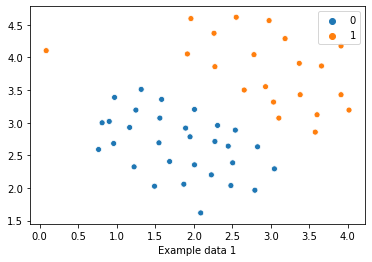

In [2]:
data = scipy.io.loadmat('ex6data1.mat')
print(data.keys())
X1 = data['X']
y1 = data['y']
print(X1.shape, y1.shape)
fig_data1 = plt.figure()
ax_data1 = fig_data1.add_subplot(111) 
ax_data1 = sns.scatterplot(x=X1.T[0], y=X1.T[1], hue=y1.ravel())
ax_data1.set(xlabel='Example data 1')

In [3]:
# Function to plot Training data with linear decision boundary.
def svmlplot(clf, X, y, c):
    
    title = "SVM Linear Classification C = {}".format(c)
    fig_svmex1 = plt.figure()
    ax_svmex1 = fig_svmex1.add_subplot(111) 
    sns.scatterplot(x=X.T[0], y=X.T[1], hue=y.ravel(),ax=ax_svmex1)
    
    # One way to plot decision boundary: x2 = -(Theta1.x1 + Theta0)/Theta2
    #xp = np.linspace(np.min(X[:,:1]),np.max(X[:,:1]), num=100)
    #yp = - (clf.coef_[0][0]*xp + clf.intercept_)/clf.coef_[0][1]
    #sns.lineplot(x=xp, y=yp, ax=ax_svmex1)
    
    # Another way is using meshgrid and decision function
    xlim = ax_svmex1.get_xlim()
    ylim = ax_svmex1.get_ylim()
    xx = np.linspace(xlim[0], xlim[1], 30)
    yy = np.linspace(ylim[0], ylim[1], 30)
    XX, YY = np.meshgrid(xx, yy)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T
    Z = clf.decision_function(xy)
    # we can also calculate the decision function manually
    #Z = xy.dot(clf.coef_.T) + clf.intercept_
    #Z = Z.ravel()
    Z = Z.reshape(XX.shape)
    
    # plot decision boundary and margins
    CL = ax_svmex1.contour(XX, YY, Z, levels=[-1, 0, 1], colors='k', alpha=0.5,
                           linestyles=['--', '-', '--'])
    ax_svmex1.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=100,
                        linewidth=1, facecolors='none', edgecolors='k')
    ax_svmex1.clabel(CL, inline=1, fontsize=10)

    ax_svmex1.set(xlabel="Example data 1")
    fig_svmex1.suptitle(title, fontsize=16)

In [4]:
# Function which returns classifier fitted for given data using Linear Kernel
def svmex1(X, y, c):
    clf = svm.SVC(C=c, kernel='linear')
    clf.fit(X, y.ravel())
    #print("Support Vectors", clf.support_vectors_)
    #print("Indices of Support Vectors", clf.support_)
    #print("Number of Support Vectors", clf.n_support_)
    return clf

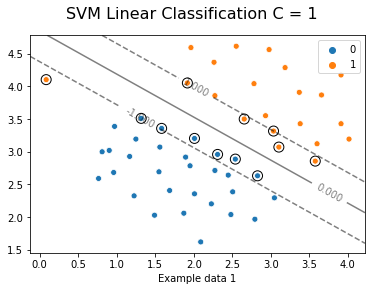

In [5]:
c = 1
clf = svmex1(X1, y1, c)
svmlplot(clf, X1, y1, c)

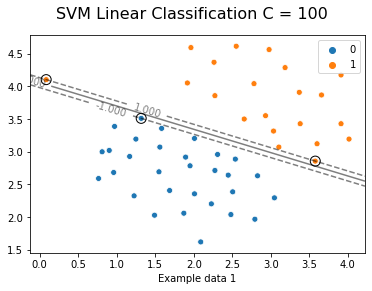

In [6]:
c = 100
clf = svmex1(X1, y1, c)
svmlplot(clf, X1, y1, c)

### SVM with Gaussian Kernels

Use SVMs to do non-linear classification using Gaussian kernels.

#### Gaussian Kernel

Gaussian kernel as a similarity function that measures the "distance" between a pair of examples, $(x^{(i)}, x^{(j)})$. The Gaussian kernel is also parameterized by a bandwidth parameter, $\sigma$, which determines how fast the similarity metric decreases (to 0) as the examples are further apart.
<br>
$$ K_{gaussian}(x^{(i)}, x^{(j)}) = exp(-\frac{||x^{(i)} - x^{(j)}||^2}{2 \sigma^2}) = exp(-\frac{\sum_{k=1}^n(x^{(i)} - x^{(j)})^2}{2 \sigma^2}) $$

In [7]:
# Closure is used since SVM with custom kernel does not allow additional parameters to be passed except X and Y
def gaussianKernel(sigma):
    def gaussianKernel_(X, Y):
        kernel = euclidean_distances(X, Y) ** 2
        kernel = kernel*(-1/(2 * sigma**2))
        kernel = np.exp(kernel)
        return kernel
    return gaussianKernel_

#### Example Dataset 2

dict_keys(['__header__', '__version__', '__globals__', 'X', 'y'])
(863, 2) (863, 1)


[Text(0.5, 0, 'Example data 2')]

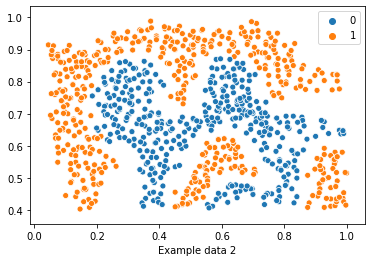

In [8]:
data = scipy.io.loadmat('ex6data2.mat')
print(data.keys())
X2 = data['X']
y2 = data['y']
print(X2.shape, y2.shape)
fig_svmex2 = plt.figure()
ax_svmex2 = fig_svmex2.add_subplot(111)
ax_svmex2 = sns.scatterplot(x=X2.T[0], y=X2.T[1], hue=y2.ravel(),ax=ax_svmex2)
ax_svmex2.set(xlabel='Example data 2')

In [9]:
# Function to plot Training data with non-linear decision boundary.
#  If plotval is set to 1, the will plot the same for Validation data also.
def svmnlplot(clf, X, y, Xval, yval, c, sigma, plotval):
    # Predict class for training data
    y_p = clf.predict(X)

    # Generate grid of data using training data range and predict its output.
    h = 0.02
    x_min, x_max = X[:, 0].min(), X[:, 0].max()
    y_min, y_max = X[:, 1].min(), X[:, 1].max()
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    if(plotval == 1):
        # Generate grid of data using validation data range and predict its output.
        x_minv, x_maxv = Xval[:, 0].min(), Xval[:, 0].max()
        y_minv, y_maxv = Xval[:, 1].min(), Xval[:, 1].max()
        xxv, yyv = np.meshgrid(np.arange(x_minv, x_maxv, h), np.arange(y_minv, y_maxv, h))
        Zv = clf.predict(np.c_[xxv.ravel(), yyv.ravel()])
        Zv = Zv.reshape(xxv.shape)
    
    if(plotval == 1):
        # Use 2x1 plot if plotting both training and validation data
        fig_svm = plt.figure(figsize=(10,4))
        ax_svmt = fig_svm.add_subplot(121)
    else:
        # Use 1x1 plot if plotting only training data
        fig_svm = plt.figure()
        ax_svmt = fig_svm.add_subplot(111)    
    
    # Plot training data and its decision boundary
    sns.scatterplot(x=X.T[0], y=X.T[1], hue=y.ravel(), ax=ax_svmt)
    CS = ax_svmt.contour(xx, yy, Z, [0.5, 0.6])
    ax_svmt.clabel(CS, inline=1, fontsize=10)
    ax_svmt.set(xlabel='Example data 3 -Training')
    
    if(plotval == 1):
        # Plot validation data and its decision boundary
        ax_svmv = fig_svm.add_subplot(122)
        sns.scatterplot(x=Xval.T[0], y=Xval.T[1], hue=yval.ravel(), ax=ax_svmv)
        CSv = ax_svmv.contour(xxv, yyv, Zv, [0.5, 0.6])
        ax_svmv.set(xlabel='Example data 3 - Validation')

    title = "SVM Non-Linear Classification C = {}, Sigma = {}".format(c, sigma)
    fig_svm.suptitle(title, fontsize=16)

In [10]:
# Function which returns classifier fitted for given data using Gaussian Kernel
def svmnl(X, y, c, sigma):
    clf = svm.SVC(C=c, kernel=gaussianKernel(sigma))
    clf.fit(X, y.ravel())
    #print("Support Vectors", clf.support_vectors_)
    #print("Indices of Support Vectors", clf.support_)
    #print("Number of Support Vectors", clf.n_support_)
    return clf

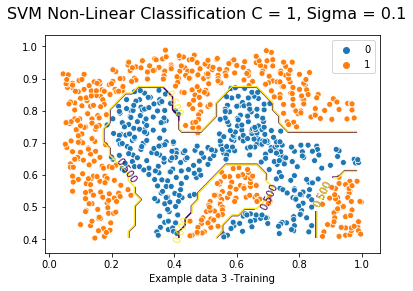

In [11]:
c, sigma = 1, 0.1
clf = svmnl(X2, y2, c, sigma)
svmnlplot(clf, X2, y2, 0, 0, c, sigma, 0)

#### Example Dataset 3

dict_keys(['__header__', '__version__', '__globals__', 'X', 'y', 'yval', 'Xval'])
(211, 2) (211, 1) (200, 2) (200, 1)


[Text(0.5, 0, 'Example data 3 - Validation')]

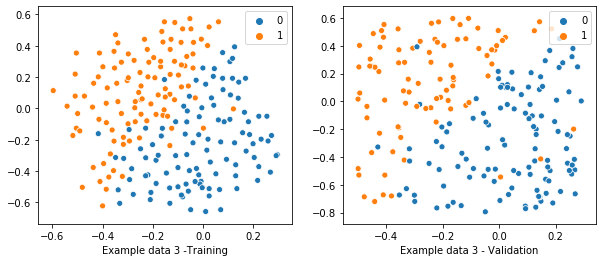

In [12]:
data = scipy.io.loadmat('ex6data3.mat')
print(data.keys())
X3 = data['X']
y3 = data['y']
X3val = data['Xval']
y3val = data['yval']
print(X3.shape, y3.shape, X3val.shape, y3val.shape)

fig_data3 = plt.figure(figsize=(10,4))
ax_data3 = fig_data3.add_subplot(121)
ax_data3 = sns.scatterplot(x=X3.T[0], y=X3.T[1], hue=y3.ravel())
ax_data3.set(xlabel='Example data 3 -Training')
ax_data4 = fig_data3.add_subplot(122)
ax_data4 = sns.scatterplot(x=X3val.T[0], y=X3val.T[1], hue=y3val.ravel())
ax_data4.set(xlabel='Example data 3 - Validation')

C = 1.0, Sigma = 0.1, Min Error = 0.035


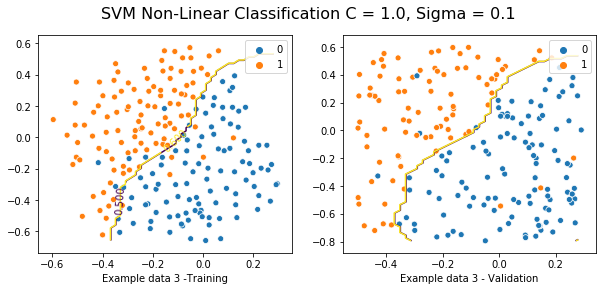

In [13]:
param = np.array([0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30])
minError, minC, minS = 5, 0, 0
for c in param:
    for s in param:
        clf = svmnl(X3, y3, c, s)
        y3_p = clf.predict(X3val)
        err = np.mean(y3_p != y3val.ravel())
        if(err < minError):
            minError = err
            minC = c
            minS = s
print("C = {}, Sigma = {}, Min Error = {}".format(minC, minS, minError))
clf = svmnl(X3, y3, minC, minS)
svmnlplot(clf, X3, y3, X3val, y3val, minC, minS, 1)

## Spam Classification

The purpose of this exercise is to build a Spam filter. This involves converting each email into a feature vector $x \in R^n$. We will use only the body of the email (excluding the email headers)
<br>The dataset included for this exercise is based on a a subset of the SpamAssassin Public Corpus - http://spamassassin.apache.org/old/publiccorpus/

### Preprocessing Emails

#### Vocabulary List

In [14]:
vocab = pd.read_csv('vocab.txt', sep="\t", header=None)
vocab.columns = ["Index", "Word"]
vocab.head()

,Index,Word
0,1,aa
1,2,ab
2,3,abil
3,4,abl
4,5,about


### Extracting features from Emails

### Training SVM for Spam Classification

In [15]:
data = scipy.io.loadmat('spamTrain.mat')
print(data.keys())
SXt = data['X']
Syt = data['y']
data = scipy.io.loadmat('spamTest.mat')
print(data.keys())
SXval = data['Xtest']
Syval = data['ytest']
print(SXt.shape, Syt.shape, SXval.shape, Syval.shape)

dict_keys(['__header__', '__version__', '__globals__', 'X', 'y'])
dict_keys(['__header__', '__version__', '__globals__', 'Xtest', 'ytest'])
(4000, 1899) (4000, 1) (1000, 1899) (1000, 1)


In [16]:
c = 0.1
Spamclf = svm.SVC(C=c, kernel='linear')
Spamclf.fit(SXt, Syt.ravel())
Syt_p = Spamclf.predict(SXt)
print("Training set accuracy {}".format(np.mean(Syt_p == Syt.ravel())))

Training set accuracy 0.99825


In [17]:
Syval_p = Spamclf.predict(SXval)
print("Test set accuracy {}".format(np.mean(Syval_p == Syval.ravel())))

Test set accuracy 0.989


### Top Predictors for Spam

In [18]:
# Get the indices of weights sorted weights
weightindex1 = np.argsort(Spamclf.coef_.ravel())
# Get descended sorted copy
weightindex2 = weightindex1[::-1]
print("Top predictors of spam:")
print("{:10} {} ".format("Word", "Weight"))
for i in range(15):
    ind = weightindex2[i]
    print("{:10} {} ".format(vocab["Word"][ind], Spamclf.coef_[0][ind]))

Top predictors of spam:
Word       Weight 
our        0.5006137361746404 
click      0.4659163906888878 
remov      0.4228691170610413 
guarante   0.3836216017940651 
visit      0.36771039824553503 
basenumb   0.34506409794617054 
dollar     0.3236320357963838 
will       0.26972410603740016 
price      0.267297714617707 
pleas      0.2611688867001497 
most       0.2572981979518163 
nbsp       0.2539414551595327 
lo         0.2534665243141993 
ga         0.2482969904556866 
hour       0.24640435783158998 


### Try own Emails

### Build own dataset